https://www.tensorflow.org/tutorials/structured_data/time_series

https://www.kaggle.com/datasets/PROPPG-PPG/hourly-weather-surface-brazil-southeast-region

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

2023-02-08 11:06:40.037259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [52]:
cwest = pd.read_csv(r'./central_west.csv')
coldesc = pd.read_csv(r'./columns_description.csv')

In [54]:
cwest.drop(columns=['index'], inplace=True)

In [55]:
mapping = pd.Series(coldesc.abbreviation.values,index=cwest.columns).to_dict()

In [56]:
cwest = cwest.rename(columns=mapping)

In [57]:
cwest['DATE'] = pd.to_datetime(cwest['date'], format='%Y-%m-%d')
cwest['TIME'] = pd.to_datetime(cwest['hr'], format='%H:%M')

cwest.drop(columns=['date', 'hr'], inplace=True)

cwest['DAY'] = cwest['DATE'].dt.day
cwest['MONTH'] = cwest['DATE'].dt.month
cwest['YEAR'] = cwest['DATE'].dt.year
cwest['HOUR'] = cwest['TIME'].dt.hour
cwest['MINUTE'] = cwest['TIME'].dt.minute
cwest['SECOND'] = cwest['TIME'].dt.second

cwest.drop(columns=['DATE','TIME'], inplace=True)

cwest['mdct'] = pd.to_datetime(cwest[['DAY','MONTH','YEAR','HOUR','MINUTE','SECOND']])

cwest.drop(columns=['DAY','MONTH','YEAR','HOUR','MINUTE','SECOND'], inplace=True)

cwest.sort_values(by='mdct', inplace=True)
cwest.reset_index(drop=True, inplace=True)

In [58]:
cwest.drop(columns=['reg','prov','wsnm'], inplace=True)

In [60]:
stat = cwest.loc[cwest['inme'] == 'A047']
stat.drop(columns=['inme'], inplace=True)

/var/folders/j3/055drx795nz293kfxbqx6vm80000gn/T/ipykernel_31027/2906265934.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat.drop(columns=['inme'], inplace=True)


In [61]:
stat.replace([-9999,-99990],0, inplace=True)
#stat.dropna(inplace=True)

/var/folders/j3/055drx795nz293kfxbqx6vm80000gn/T/ipykernel_31027/3885035522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat.replace([-9999,-99990],0, inplace=True)


In [62]:
date_time = stat.pop('mdct')

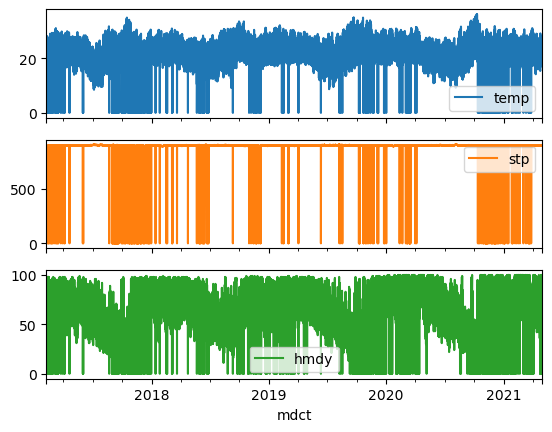

In [63]:
plot_cols = ['temp', 'stp', 'hmdy']
plot_features = stat[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots = True)

/var/folders/j3/055drx795nz293kfxbqx6vm80000gn/T/ipykernel_31027/3860451206.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plot_features.index = date_time[:480]


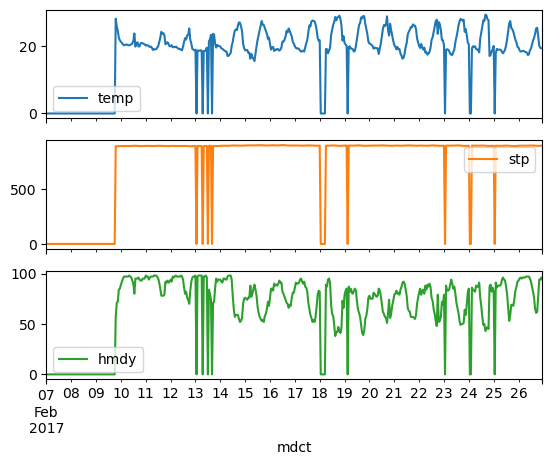

In [64]:
plot_features = stat[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots = True)

In [65]:
stat.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
prcp,37056.0,0.177607,1.591253,0.000000,0.000000,0.000000,0.000000,70.200000
stp,37056.0,884.859464,114.028895,0.000000,897.700000,899.300000,901.200000,908.900000
smax,37056.0,884.885916,114.890567,0.000000,897.900000,899.600000,901.500000,909.000000
smin,37056.0,884.396713,114.827812,0.000000,897.400000,899.100000,901.000000,908.700000
gbrd,37056.0,812.649207,1131.743778,0.000000,0.000000,23.000000,1583.000000,4293.000000
temp,37056.0,21.350240,4.918978,0.000000,18.900000,20.900000,24.500000,36.300000
dewp,37056.0,14.543750,4.903444,-7.000000,11.200000,16.200000,18.400000,23.200000
tmax,37056.0,22.106609,5.118745,0.000000,19.300000,21.600000,25.500000,37.100000
tmin,37056.0,20.628611,4.735164,0.000000,18.400000,20.200000,23.500000,35.300000
dmax,37056.0,15.198624,4.798484,-3.300000,11.900000,16.800000,18.900000,23.800000


Text(0, 0.5, 'Wind Velocity [m/s]')

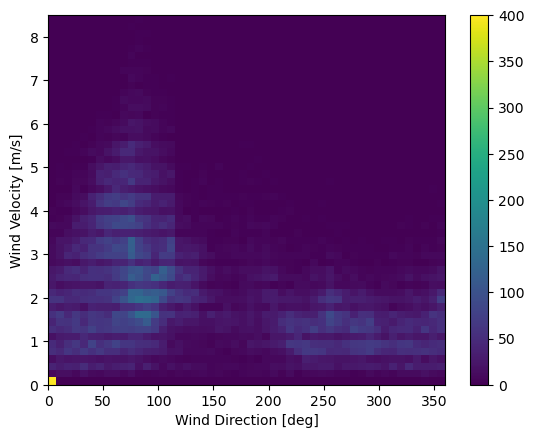

In [66]:
plt.hist2d(stat['wdct'], stat['wdsp'], bins=(50,50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [67]:
ws = stat.pop('wdsp')
wg = stat.pop('gust')

wd_rad = stat.pop('wdct') * np.pi / 180

stat['Wx'] = ws * np.cos(wd_rad)
stat['Wy'] = ws * np.sin(wd_rad)

stat['Gx'] = wg * np.cos(wd_rad)
stat['Gy'] = wg * np.sin(wd_rad)

/var/folders/j3/055drx795nz293kfxbqx6vm80000gn/T/ipykernel_31027/1149396243.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat['Wx'] = ws * np.cos(wd_rad)
/var/folders/j3/055drx795nz293kfxbqx6vm80000gn/T/ipykernel_31027/1149396243.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat['Wy'] = ws * np.sin(wd_rad)
/var/folders/j3/055drx795nz293kfxbqx6vm80000gn/T/ipykernel_31027/1149396243.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

(-6.771649583831595, 5.891231062095616, -6.550804600832725, 8.479294427208506)

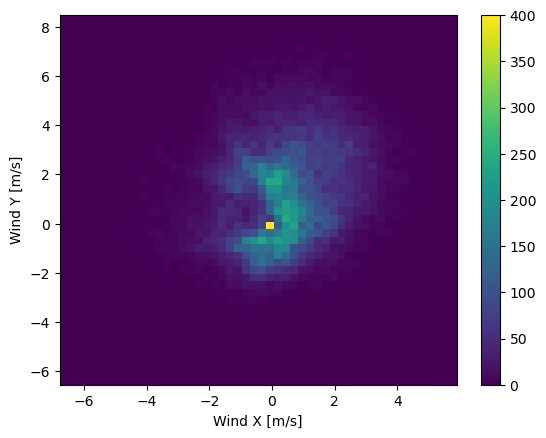

In [68]:
plt.hist2d(stat['Wx'], stat['Wy'], bins=(50,50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [69]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [70]:
day = 24*60*60
year = (365.2425)*day

stat['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
stat['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
stat['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
stat['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

/var/folders/j3/055drx795nz293kfxbqx6vm80000gn/T/ipykernel_31027/3100943720.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
/var/folders/j3/055drx795nz293kfxbqx6vm80000gn/T/ipykernel_31027/3100943720.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
/var/folders/j3/055drx795nz293kfxbqx6vm80000gn/T/ipykernel_31027/3100943720.py:6: SettingWithCopyWarning: 
A value is trying to be set on a 

Text(0.5, 1.0, 'Time of day signal')

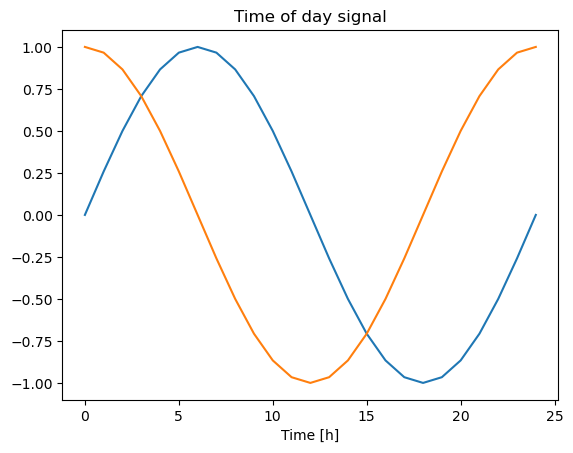

In [71]:
plt.plot(np.array(stat['Day sin'])[:25])
plt.plot(np.array(stat['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

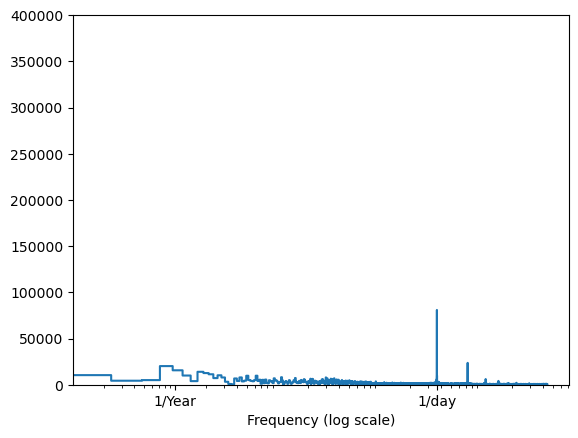

In [72]:
fft = tf.signal.rfft(stat['temp'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(stat['temp'])
hours_per_year = 24*365.2425
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [73]:
column_indices = {name: i for i, name in enumerate(stat.columns)}

n = len(stat)
train_stat = stat[0:int(n*0.7)]
val_stat = stat[int(n*0.7):int(n*0.9)]
test_stat = stat[int(n*0.9):]

num_features = stat.shape[1]

In [74]:
train_mean = train_stat.mean()
train_std = train_stat.std()

train_stat = (train_stat - train_mean) / train_std
val_stat = (val_stat - train_mean) / train_std
test_stat = (test_stat - train_mean) / train_std

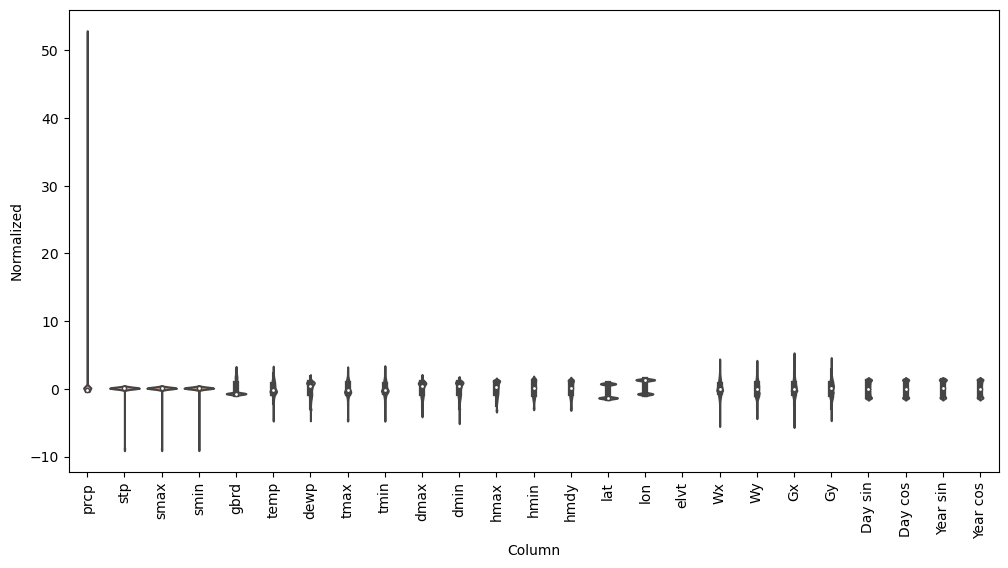

In [75]:
df_std = (stat - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(stat.keys(), rotation=90)

In [76]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df=train_stat, val_df=val_stat, test_df=test_stat,
                label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                         enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                              enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='temp', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                    label='Inputs', marker='.', zorder=-10)
        
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                       edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                           marker='X', edgecolors='k', label='Predictions',
                           c='#ff7f0e', s=64)

            if n==0:
                plt.legend()
            
        plt.xlabel('Time [h]')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32)
        
        ds = ds.map(self.split_window)
        
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

In [77]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                    label_columns=['temp'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['temp']

In [78]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                    label_columns=['temp'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['temp']

In [79]:
example_window = tf.stack([np.array(train_stat[:w2.total_window_size]),
                           np.array(train_stat[100:100+w2.total_window_size]),
                           np.array(train_stat[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 7, 25)
Inputs shape: (3, 6, 25)
Labels shape: (3, 1, 1)


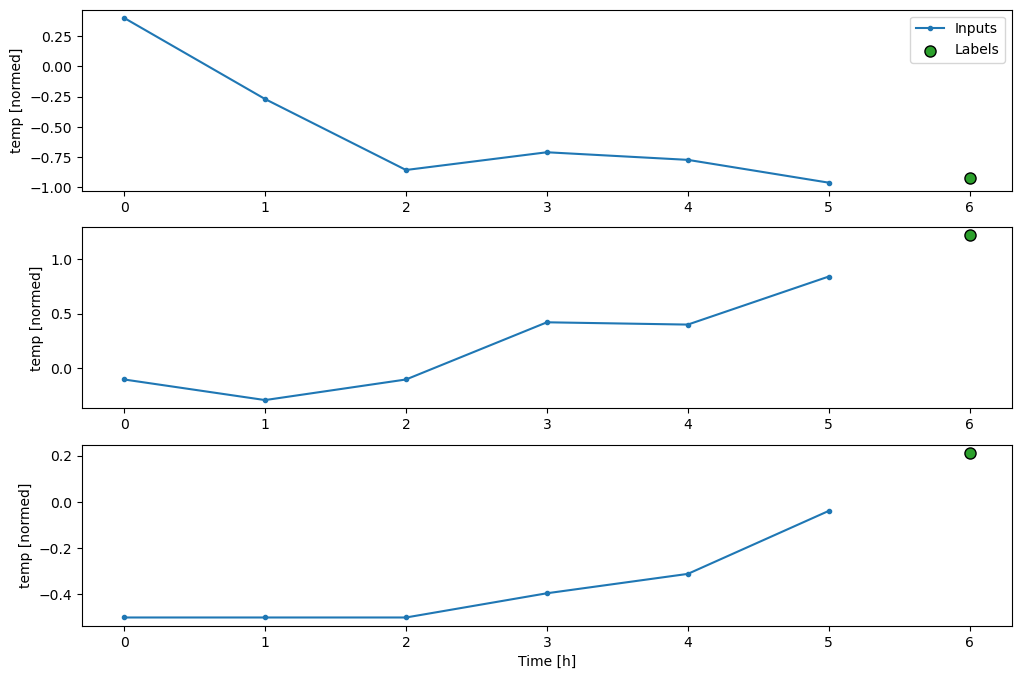

In [80]:
w2.plot()

In [81]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 25), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [82]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['temp'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['temp']

In [83]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 25)
Labels shape (batch, time, features): (32, 1, 1)


In [91]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [93]:
baseline = Baseline(label_index=column_indices['temp'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

232/232 [==============================] - 0s 919us/step - loss: 0.3175 - mean_absolute_error: 0.2516


In [94]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['temp'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['temp']

In [95]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 25)
Output shape: (32, 24, 1)


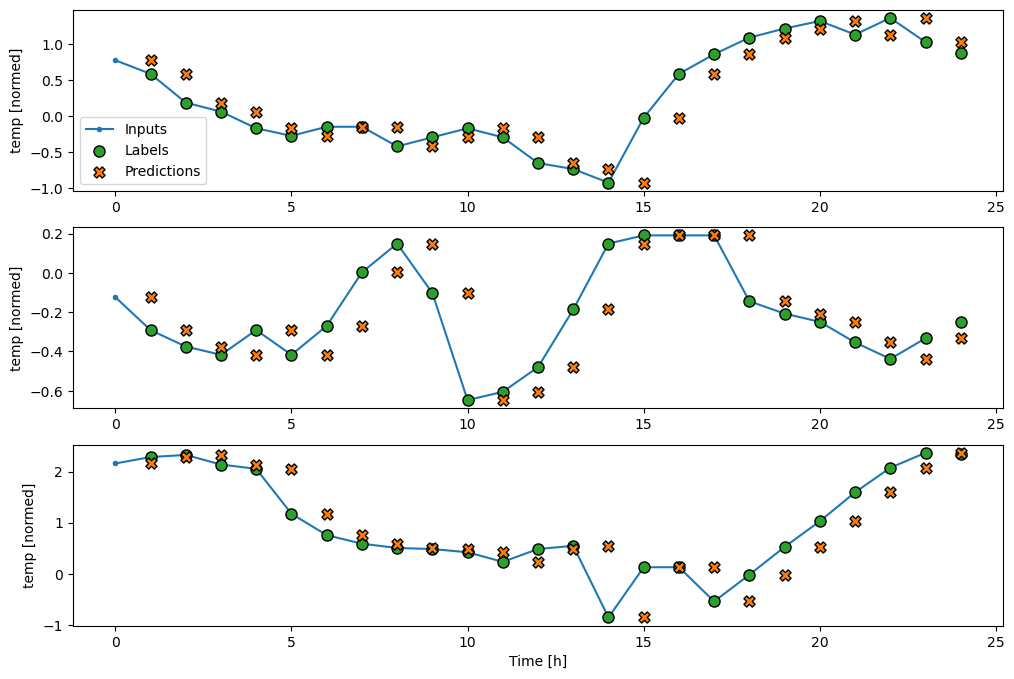

In [96]:
wide_window.plot(baseline)

In [97]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [98]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 25)
Output shape: (32, 1, 1)


In [99]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=patience,
                                                     mode='min')
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    return history

In [100]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
811/811 [==============================] - 1s 1ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/20
232/232 [==============================] - 0s 867us/step - loss: nan - mean_absolute_error: nan


In [101]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 25)
Output shape: (32, 24, 1)


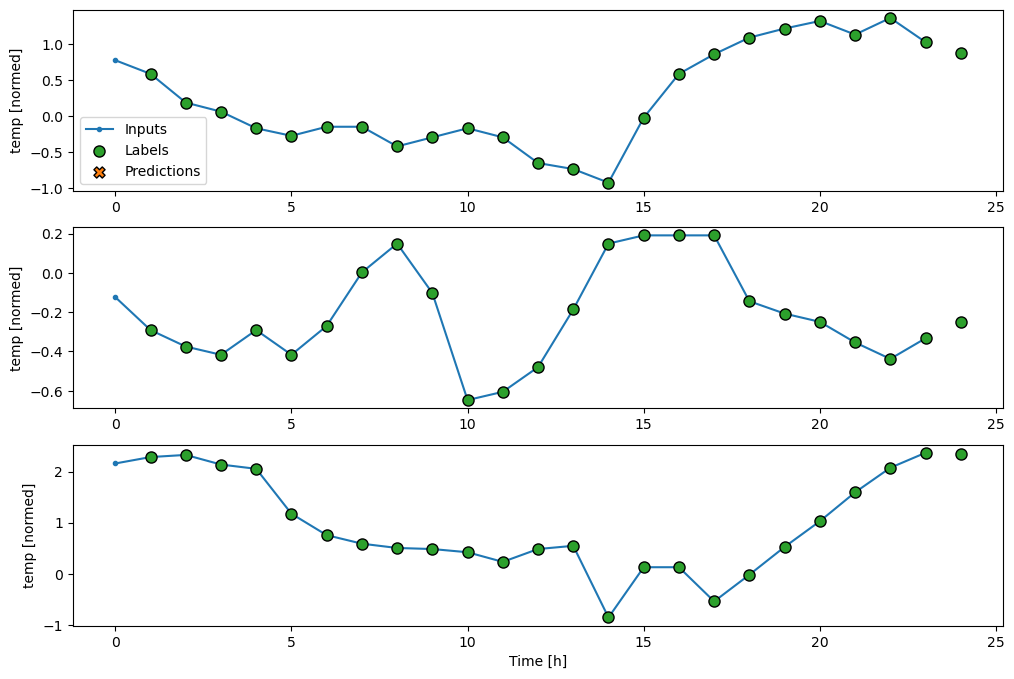

In [102]:
wide_window.plot(linear)

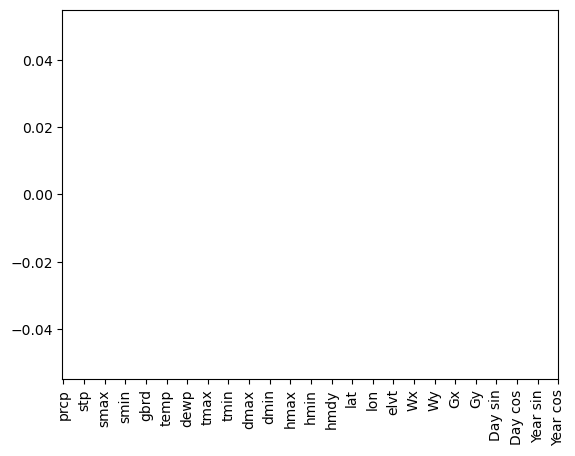

In [104]:
plt.bar(x = range(len(train_stat.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_stat.columns)))
_ = axis.set_xticklabels(train_stat.columns, rotation=90)